# Train a VAE on Cell Painting LINCS Data

In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
sys.path.insert(0, "../../scripts")
from utils import load_data


from pycytominer.cyto_utils import infer_cp_features


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.decomposition import PCA
from tensorflow import keras

from vae import VAE

from tensorflow.keras.models import Model, Sequential
import seaborn
import random as python_random
import tensorflow as tf


In [4]:
def remove_moa(df):
    pipes = ['benzodiazepine receptor agonist|HDAC inhibitor'
         'CDK inhibitor|glycogen synthase kinase inhibitor',
             'DNA synthesis inhibitor|microtubule inhibitor',
             'antiviral|RNA synthesis inhibitor',
            'AKT inhibitor|mTOR inhibitor']    
    moas =  []
    for pipe in pipes:
        moas.append(pipe)
        moas.append(pipe.split('|')[0])
        moas.append(pipe.split('|')[1])
    return df[~df.moa.isin(moas)]

In [5]:
data_splits = ["train", "test", "valid","complete"]
data_dict = load_data(data_splits)

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [6]:
# Prepare data for training
meta_features = infer_cp_features(data_dict["train"], metadata=True)
cp_features = infer_cp_features(data_dict["train"])

moa_df_train = pd.read_csv("../3.application/repurposing_info_external_moa_map_resolved.tsv",sep='\t').set_index('broad_sample').reindex(index=data_dict['train']['Metadata_broad_sample']).reset_index().drop('Metadata_broad_sample',axis = 1)
data_dict['train'] = pd.concat([moa_df_train,data_dict['train']], axis=1)

moa_df_valid = pd.read_csv("../3.application/repurposing_info_external_moa_map_resolved.tsv",sep='\t').set_index('broad_sample').reindex(index=data_dict['valid']['Metadata_broad_sample']).reset_index().drop('Metadata_broad_sample',axis = 1)
data_dict['valid'] = pd.concat([moa_df_valid,data_dict['valid']], axis=1)

data_dict['train'] = remove_moa(data_dict['train'])
data_dict['valid'] = remove_moa(data_dict['valid'])

train_features_df = data_dict["train"].reindex(cp_features, axis="columns")
train_meta_df = data_dict["train"].reindex(meta_features, axis="columns")

test_features_df = data_dict["test"].reindex(cp_features, axis="columns")
test_meta_df = data_dict["test"].reindex(meta_features, axis="columns")

valid_features_df = data_dict["valid"].reindex(cp_features, axis="columns")
valid_meta_df = data_dict["valid"].reindex(meta_features, axis="columns")

complete_features_df = data_dict["complete"].reindex(cp_features, axis="columns")
complete_meta_df = data_dict["complete"].reindex(meta_features, axis="columns")


In [7]:
print(train_features_df.shape)
train_features_df.head(3)

(39473, 685)


,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_MedianRadius,Cells_AreaShape_Orientation,Cells_AreaShape_Solidity,Cells_AreaShape_Zernike_0_0,Cells_AreaShape_Zernike_1_1,Cells_AreaShape_Zernike_2_0,...,Nuclei_Texture_SumEntropy_DNA_5_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumEntropy_RNA_20_0,Nuclei_Texture_SumEntropy_RNA_5_0,Nuclei_Texture_SumVariance_DNA_20_0,Nuclei_Texture_SumVariance_RNA_20_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_ER_20_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_20_0
0,0.19790,0.69605,0.40400,0.30834,0.19317,0.71895,0.38837,0.38668,0.62494,0.87362,...,0.61045,0.41907,0.64945,0.65199,0.22660,0.32108,0.29776,0.26173,0.34524,0.32151
1,0.18605,0.68873,0.41051,0.31982,0.19885,0.72510,0.39552,0.38362,0.65094,0.89679,...,0.61393,0.38269,0.63814,0.68204,0.23700,0.32808,0.27981,0.26893,0.34938,0.33179
2,0.19083,0.66276,0.38585,0.31437,0.20415,0.71380,0.38701,0.36699,0.60932,0.88492,...,0.60850,0.41850,0.63529,0.65208,0.22852,0.32710,0.29371,0.27159,0.33871,0.31965


In [8]:
print(test_features_df.shape)
test_features_df.head(3)

(5030, 685)


,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_MedianRadius,Cells_AreaShape_Orientation,Cells_AreaShape_Solidity,Cells_AreaShape_Zernike_0_0,Cells_AreaShape_Zernike_1_1,Cells_AreaShape_Zernike_2_0,...,Nuclei_Texture_SumEntropy_DNA_5_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumEntropy_RNA_20_0,Nuclei_Texture_SumEntropy_RNA_5_0,Nuclei_Texture_SumVariance_DNA_20_0,Nuclei_Texture_SumVariance_RNA_20_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_ER_20_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_20_0
0,0.19050,0.68937,0.39383,0.33072,0.20185,0.72292,0.38085,0.37504,0.61905,0.88361,...,0.60356,0.39345,0.63470,0.63406,0.23588,0.36061,0.30092,0.23638,0.36015,0.32779
1,0.18661,0.67731,0.39621,0.32318,0.20716,0.70964,0.39401,0.37779,0.60275,0.88912,...,0.60936,0.40380,0.64406,0.64859,0.22752,0.29811,0.29430,0.25475,0.34154,0.32013
2,0.18626,0.67036,0.41101,0.31863,0.20182,0.71139,0.40302,0.38979,0.59188,0.86857,...,0.61009,0.40904,0.64250,0.63285,0.23931,0.33179,0.28571,0.24980,0.34516,0.32968


In [9]:
print(complete_features_df.shape)
complete_features_df.head(3)

(50303, 685)


,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_MedianRadius,Cells_AreaShape_Orientation,Cells_AreaShape_Solidity,Cells_AreaShape_Zernike_0_0,Cells_AreaShape_Zernike_1_1,Cells_AreaShape_Zernike_2_0,...,Nuclei_Texture_SumEntropy_DNA_5_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumEntropy_RNA_20_0,Nuclei_Texture_SumEntropy_RNA_5_0,Nuclei_Texture_SumVariance_DNA_20_0,Nuclei_Texture_SumVariance_RNA_20_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_ER_20_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_20_0
0,0.19575,0.67566,0.40288,0.32633,0.20267,0.71477,0.39122,0.38048,0.61184,0.88375,...,0.60865,0.38869,0.65364,0.65716,0.24912,0.33129,0.28864,0.27106,0.35254,0.32675
1,0.18472,0.66556,0.39721,0.30968,0.20009,0.71345,0.39953,0.37314,0.61074,0.87695,...,0.60682,0.39779,0.64013,0.63120,0.24380,0.30471,0.28554,0.27852,0.35157,0.31637
2,0.18254,0.69650,0.39596,0.33502,0.20420,0.72770,0.39590,0.37023,0.60264,0.88038,...,0.60665,0.39705,0.66616,0.62889,0.25125,0.33549,0.29656,0.25706,0.33868,0.31901


In [10]:
# VAE of one layer

encoder_architecture = [250]
decoder_architecture = [250]


In [11]:

cp_vae = VAE(
    input_dim=train_features_df.shape[1],
    latent_dim=90,
    batch_size=32,
    encoder_batch_norm=True,
    epochs=50,
    learning_rate=0.0001,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=0,
    lam=10000,
    verbose=True,
)


cp_vae.compile_vae()

In [12]:
cp_vae.train(x_train=train_features_df, x_test=valid_features_df)

Epoch 1/50
1234/1234 [==============================] - 9s 6ms/step - loss: 139.3907 - recon: 56.3837 - kl: 0.0000e+00 - mmd: 18.4200 - val_loss: 39.3186 - val_recon: 12.5756 - val_kl: 0.0000e+00 - val_mmd: 27.2772
Epoch 2/50
1234/1234 [==============================] - 6s 5ms/step - loss: 25.2227 - recon: 7.5704 - kl: 0.0000e+00 - mmd: 15.9756 - val_loss: 24.1150 - val_recon: 5.5070 - val_kl: 0.0000e+00 - val_mmd: 18.6508
Epoch 3/50
1234/1234 [==============================] - 6s 5ms/step - loss: 19.8130 - recon: 4.4619 - kl: 0.0000e+00 - mmd: 14.8029 - val_loss: 37.1259 - val_recon: 4.7650 - val_kl: 0.0000e+00 - val_mmd: 32.1840
Epoch 4/50
1234/1234 [==============================] - 6s 5ms/step - loss: 17.4621 - recon: 3.0334 - kl: 0.0000e+00 - mmd: 14.1204 - val_loss: 32.2422 - val_recon: 2.6386 - val_kl: 0.0000e+00 - val_mmd: 29.2642
Epoch 5/50
1234/1234 [==============================] - 6s 5ms/step - loss: 16.0987 - recon: 2.1711 - kl: 0.0000e+00 - mmd: 13.7078 - val_loss: 23.95

In [13]:
cp_vae.vae

In [14]:
# Save training performance
history_df = pd.DataFrame(cp_vae.vae.history.history)
history_df

,loss,recon,kl,mmd,val_loss,val_recon,val_kl,val_mmd
0,74.863663,56.383678,0.0,18.420048,39.318588,12.575617,0.0,27.277248
1,23.334579,7.570421,0.0,15.975617,24.114958,5.507032,0.0,18.650755
2,19.221558,4.461895,0.0,14.802872,37.125950,4.765013,0.0,32.184040
3,17.180372,3.033413,0.0,14.120376,32.242188,2.638580,0.0,29.264250
4,15.898522,2.171108,0.0,13.707837,23.951651,1.951921,0.0,22.148098
5,15.234391,1.630502,0.0,13.548157,26.980156,1.473006,0.0,25.893681
6,14.757110,1.308802,0.0,13.371398,23.555387,1.207477,0.0,21.859282
7,14.402693,1.109632,0.0,13.250370,27.721931,1.053477,0.0,26.725868
8,14.067601,0.977579,0.0,13.182675,30.014460,0.937918,0.0,29.223497
9,14.051779,0.901837,0.0,13.106303,32.121037,0.836444,0.0,31.330608


In [15]:
history_df.to_csv('training_data/level4_training_mmd_leaveOut.csv')

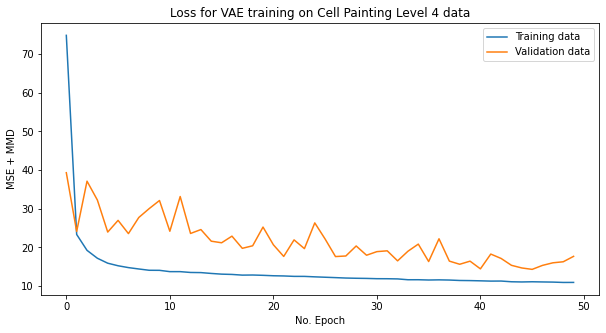

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(history_df["loss"], label="Training data")
plt.plot(history_df["val_loss"], label="Validation data")
plt.title("Loss for VAE training on Cell Painting Level 4 data")
plt.ylabel("MSE + MMD")
plt.xlabel("No. Epoch")
plt.legend()
plt.show()

In [18]:
cp_vae.vae.evaluate(test_features_df)

158/158 [==============================] - 0s 2ms/step - loss: 17.5727 - recon: 0.5121 - kl: 0.0000e+00 - mmd: 17.4159


[17.572721481323242, 0.5121245384216309, 0.0, 17.41594123840332]

In [19]:
reconstruction = pd.DataFrame(cp_vae.vae.predict(test_features_df), columns=cp_features)
(sum(sum((np.array(test_features_df) - np.array(reconstruction)) ** 2))) ** 0.5

50.73478833415922

<AxesSubplot:>

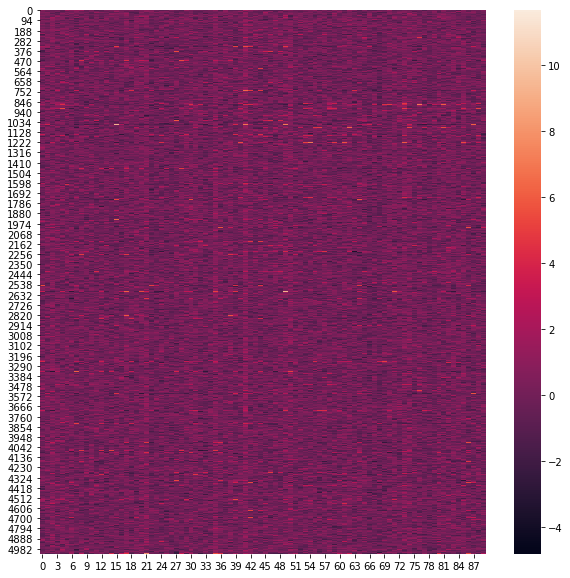

In [20]:
#latent space heatmap
fig, ax = plt.subplots(figsize=(10, 10))
encoder = cp_vae.encoder_block["encoder"]
latent = np.array(encoder.predict(test_features_df)[2])
seaborn.heatmap(latent, ax=ax)

In [21]:

reconstruction = pd.DataFrame(cp_vae.vae.predict(test_features_df), columns=cp_features)
pca = PCA(n_components=2).fit(test_features_df)
pca_reconstructed_latent_df = pd.DataFrame(pca.transform(reconstruction))
pca_test_latent_df = pd.DataFrame(pca.transform(test_features_df))


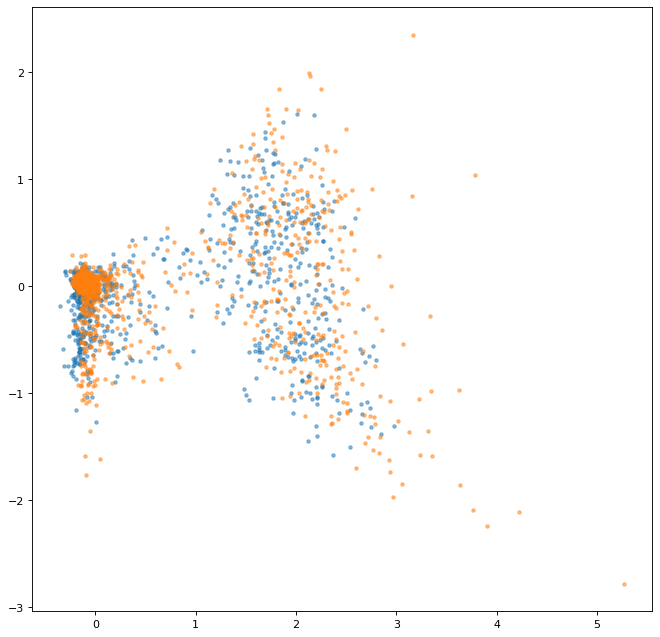

In [22]:
figure(figsize=(10, 10), dpi=80)
plt.scatter(pca_test_latent_df[0],pca_test_latent_df[1], marker = ".", alpha = 0.5)
plt.scatter(pca_reconstructed_latent_df[0],pca_reconstructed_latent_df[1], marker = ".", alpha = 0.5)

In [25]:
decoder = cp_vae.decoder_block["decoder"]

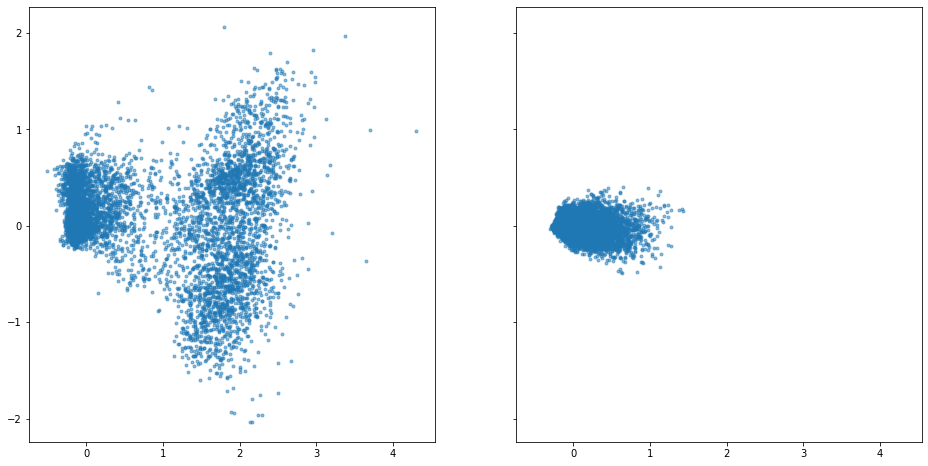

In [26]:
pca_training = PCA(n_components=2).fit(train_features_df)

simulated_df = pd.DataFrame(np.random.normal(size=(40242, 90)), columns=np.arange(0,90))
reconstruction_of_simulated = decoder.predict(simulated_df)
pca_reconstruction_of_simulated = pd.DataFrame(pca_training.transform(reconstruction_of_simulated))
pca_train_latent_df = pd.DataFrame(pca_training.transform(train_features_df))

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,8), sharey = True, sharex = True)
ax1.scatter(pca_train_latent_df[0],pca_train_latent_df[1], marker = ".", alpha = 0.5)
ax2.scatter(pca_reconstruction_of_simulated[0],pca_reconstruction_of_simulated[1], marker = ".", alpha = 0.5)

In [27]:
from scipy.spatial.distance import directed_hausdorff
max(directed_hausdorff(reconstruction_of_simulated, train_features_df)[0],directed_hausdorff(train_features_df,reconstruction_of_simulated)[0])

8.876286746699929

In [31]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
latent_complete = np.array(encoder.predict(complete_features_df)[2])
latent_df = pd.DataFrame(latent)
latent_df.to_csv("../3.application/level4Latent_mmd_leaveOut.csv")

In [32]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
decoder.save("models/level4Decoder_mmd_leaveOut")

INFO:tensorflow:Assets written to: level4Decoder_mmd_leaveOut/assets


In [33]:
encoder.save("models/level4Encoder_mmd_leaveOut")

INFO:tensorflow:Assets written to: level4Encoder_mmd_leaveOut/assets
